<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/O2_prediction_model_Network_C_O2T_Paper_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code related to the paper on the prediction of $[O2]$ and $T$ at the same time with MTL - Network C  

Author: Umberto Michelucci

**Version 3.0**


## Dataset 1 -- $\theta / 90$

We first import the libraries we need. Many are non necessary but are useful to write shorter code. For example one you have imported `keras` you don't need to `from tensorflow.keras.models import Sequential` but this makes some of the code shorter. In fact instead of writing `keras.models.Sequential()` you can simply use `Sequential()`.

In [1]:
# Basics
import numpy as np
import pandas as pd

# for timing measurements
import time

# Only in Google Colab
#%tensorflow_version 2.x

import tensorflow as tf

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras.backend as K

# Various
from numpy import random
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns



print(tf.__version__)

2.1.0-rc1


# Input data load

Depending if you are running this code on Google Colab or locally run the appropriate cells. Note that if you want to run the notebook on Colab, you will need to have the files in the appropriate directory. In particular you need

`../data/train_data1.csv`

`../data/train_targets1.csv`


## Read the files (Google Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
root_dir = "/content/gdrive/My Drive/Datasets/O2TRealData"
!ls /content/gdrive/My\ Drive/Datasets/O2TRealData

## Read the files (Google Drive)

Note that this line, **at the moment**, is exactly the same as the local one, since the location of the files is the same. This may change depending on where the files are saved in google drive. 

In [ ]:
train_data_df = pd.read_csv(root_dir + '/train_data1.csv', header = None)
train_target_df = pd.read_csv(root_dir + '/train_targets1.csv', names=['T', 'O2'], header = None)

## Read the files (Local files)

In [2]:
train_data_df = pd.read_csv('../data/train_data1.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets1.csv', names=['T', 'O2'], header = None)

In [3]:
train_data_df.shape

(3780, 50)

In [4]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.026933,-0.040467,-0.053667,-0.067067,-0.080400,-0.093333,-0.106267,-0.119067,-0.131733,-0.162200,...,-0.636400,-0.643267,-0.650067,-0.656533,-0.6628,-0.685600,-0.705667,-0.723333,-0.739133,-0.753067
1,-0.027000,-0.040400,-0.053800,-0.067133,-0.080333,-0.093333,-0.106267,-0.119000,-0.131600,-0.162133,...,-0.636333,-0.643267,-0.650067,-0.656533,-0.6628,-0.685600,-0.705667,-0.723333,-0.739133,-0.753067
2,-0.027000,-0.040467,-0.053667,-0.067133,-0.080333,-0.093333,-0.106200,-0.119000,-0.131667,-0.162200,...,-0.636467,-0.643400,-0.650200,-0.656533,-0.6628,-0.685600,-0.705667,-0.723467,-0.739133,-0.753067
3,-0.027000,-0.040400,-0.053867,-0.067267,-0.080267,-0.093400,-0.106267,-0.119000,-0.131733,-0.162200,...,-0.636467,-0.643400,-0.650200,-0.656667,-0.6628,-0.685600,-0.705667,-0.723333,-0.739133,-0.753067
4,-0.027067,-0.040467,-0.053733,-0.067133,-0.080400,-0.093333,-0.106333,-0.119067,-0.131667,-0.162333,...,-0.636467,-0.643400,-0.650133,-0.656600,-0.6628,-0.685733,-0.705667,-0.723467,-0.739133,-0.753267


In [5]:
train_target_df.head()

,T,O2
0,20.0,35.0
1,20.0,35.0
2,20.0,35.0
3,20.0,35.0
4,20.0,35.0


Note that `T` is measured in degree centigrade ($^\circ \ C$), and the oxygen concentration $[O_2]$ in % Air. We normlize to have a maximum of one. This would not be strictly necessary.

In [6]:
train_target_df[['O2']] = train_target_df[['O2']]/100.0
train_target_df[['T']] = train_target_df[['T']]/45.0

Note that the values for $T$ are going from 0 to 1. To obtin the actual temperature in Celsius degrees, you need to multiply by $45$.

In [7]:
print(train_target_df['T'].unique())
print(train_target_df['T'].unique()*45)

[0.44444444 0.55555556 0.22222222 0.66666667 0.77777778 0.33333333
 0.88888889 1.         0.11111111]
[20. 25. 10. 30. 35. 15. 40. 45.  5.]


## Dataset Dimensions Checks

In [8]:
train_data_df.shape

(3780, 50)

In [9]:
train_target_df[train_target_df['T'] == 5./45.].shape

(420, 2)

To check how many values we have for each temperature we can do easily with ```groupby()```.

In [10]:
train_target_df.groupby('T').count()

,O2
T,
0.111111,420
0.222222,420
0.333333,420
0.444444,420
0.555556,420
0.666667,420
0.777778,420
0.888889,420
1.000000,420


Each of the temperature has 420 observations.

In [11]:
train_target_df.groupby('T').nunique()

,T,O2
T,,
0.111111,1,21
0.222222,1,21
0.333333,1,21
0.444444,1,21
0.555556,1,21
0.666667,1,21
0.777778,1,21
0.888889,1,21
1.000000,1,21


And each temperature has 21 unique values of oxygen concentration.

In [12]:
np.sort(train_target_df[train_target_df['T'] == 5./45.]['O2'].unique())*100

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

## Reset the index

In [13]:
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);

The unique values of the temperature ($T$) are, as expected

In [14]:
np.unique(train_target_df['T'])*45

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.])

# Frequency values

In [15]:
wred = [  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.]

# Dataset split

In [16]:
np.random.seed(42)
rnd = np.random.rand(len(train_target_df)) < 0.8

Note that the values of $\theta$ are negative in the original dataset, and therefore we convert it to positive. This was a test to see if learning was more efficient. A complete comparison has not have been done and is not clear if this really brings benefits. At the moment the working hypothesis is that positive values works better.

In [17]:
data_train = -train_data_df[rnd]
data_dev = -train_data_df[~rnd]
targets_train = train_target_df[rnd]
targets_dev = train_target_df[~rnd]

Since the inputs are measurements of a phase divided by 90, the values will remain below 1.

In [18]:
print(np.max(np.max(data_train)))
print(np.min(np.min(data_train)))

0.8895333333333335
0.015


In [19]:
print('Number of training data observations is ', data_train.shape)
print('Number of dev      data observations is ', data_dev.shape)

Number of training data observations is  (3024, 50)
Number of dev      data observations is  (756, 50)


# Plot 1

Let's check some data observations to get an idea of how they looks like.

In [22]:
train_target_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0]

T     0.111111
O2    0.050000
Name: 1760, dtype: float64

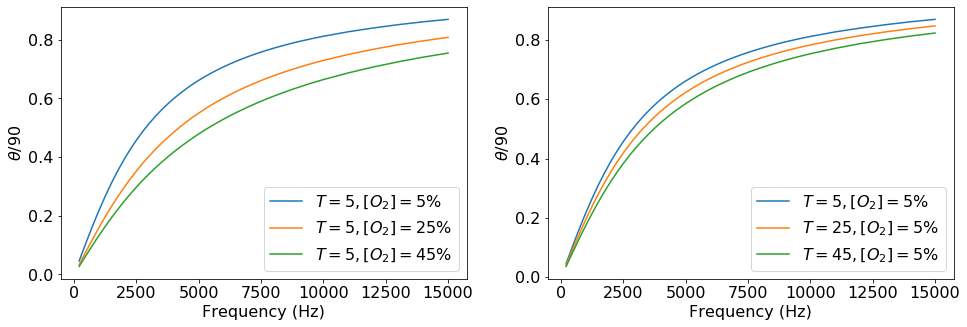

In [23]:
fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)

ax.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=5, [O_2]=5 \%$' )
ax.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 25./100.)].iloc[0], label = '$T=5, [O_2]=25 \%$' )
ax.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 45./100.)].iloc[0], label = '$T=5, [O_2]=45 \%$' )
ax.legend(fontsize = 16)
ax.tick_params(labelsize=16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / 90$', fontsize = 16)


ax2 = fig.add_subplot(1, 2, 2)


ax2.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=5, [O_2]=5 \%$' )
ax2.plot(wred, -train_data_df[(train_target_df['T'] == 25./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=25, [O_2]=5 \%$' )
ax2.plot(wred, -train_data_df[(train_target_df['T'] == 45./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=45, [O_2]=5 \%$' )
ax2.legend(fontsize = 16)
ax2.tick_params(labelsize=16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / 90$', fontsize = 16)
plt.show()

Text(0, 0.5, '$\\theta / 90$')

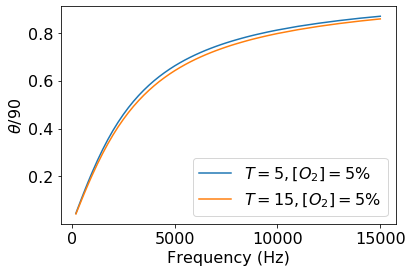

In [24]:
plt.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=5, [O_2]=5 \%$' )
plt.plot(wred, -train_data_df[(train_target_df['T'] == 15./45.) & (train_target_df['O2'] == 5./100.)].iloc[0], label = '$T=15, [O_2]=5 \%$' )
#plt.plot(wred, -train_data_df[(train_target_df['T'] == 5./45.) & (train_target_df['O2'] == 45./100.)].iloc[0], label = '$T=5, [O_2]=45 \%$' )
plt.legend(fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / 90$', fontsize = 16)

**NOTE**: looking at how similar those two curves are, we expect that detecting the temperature will be more difficult.

## Helper Functions

In [20]:
def MAE_T_list_generator(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks

In [21]:
def MAE_O2_list_generator(step, targets_dev, preds_df):
    breaks = np.arange(step,101.0, step)
    MAE_list = []
    MAE_xticks = []
    MAE_boxplot = []
    for O2_ in breaks:
        elmts = (targets_dev['O2'] < O2_/100.0) & (targets_dev['O2'] >= (O2_-step)/100.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(100*np.abs(tmp2_['O2'].values- tmp_['O2'].values))

        #print ("MAE for range [", int(O2_), ",", int(O2_-step), "] is", mae_)

        MAE_boxplot.append(list(100.0*np.abs(tmp_['O2'].values-tmp2_['O2'].values)))

        MAE_list.append(mae_)
        MAE_xticks.append("["+ str(int(O2_-step))+ ","+ str(int(O2_))+ "]")
    
    return MAE_boxplot, MAE_list, MAE_xticks

In [22]:
# Get predictions
def get_predictions(model, targets_dev, data_dev):
    preds = model.predict(data_dev)
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['O2', 'T']
    targets_dev_ = targets_dev.reset_index(drop = True)
    preds_df_ = preds_df.reset_index(drop = True)
    
    return targets_dev_, preds_df_

In [23]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 1000 == 0):
            print ("Just finished epoch", epoch)
            print (logs)
            return
        
class CustomCallbackProgress(keras.callbacks.Callback):
    
    def __init__(self, totalEpochs, step):
        self.step = 0
        self.totalEpochs = totalEpochs
        self.step = step
        
        
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 200 == 0):
            i = int(epoch / 200)
            
            if (i > 0):
                numberOfEquals = int(self.totalEpochs/200*i)
                percent = 100/(self.totalEpochs/200)*i
            else:
                numberOfEquals = 0
                percent = 0
                
                
            print ("\r[%-20s] %d%%" % ('='*i, percent), end='')
            
            if(percent == 100):
                print('')
        

In [24]:
def reset_keras():
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())

In [25]:
def average_runs(n_iter, model_):
    MAE_O2_boxplot_avg = [0]*9
    MAE_T_boxplot_avg = [0]*5

    for i in range(n_iter):
        print ("Training iteration ", i)
        
        model_.fit(data_train, targets_train, epochs=4001, batch_size=1000,verbose = 0,
             validation_data= (data_dev, targets_dev), callbacks = [CustomCallbackProgress(4000,200)])

        print("Getting predictions for iteration ",i)
        targets_dev_, preds_df_ = get_predictions(model_, targets_dev, data_dev)
        targets_train_, preds_train_ = get_predictions(model_, targets_train, data_train)

        print("Generating MAE lists for iteration ", i)
        MAE_boxplot_, MAE_list_, MAE_xticks_ = MAE_O2_list_generator(10.0, targets_dev_, preds_df_)
        MAE_T_boxplot_, MAE_T_list_, MAE_T_xticks_ = MAE_T_list_generator(targets_dev_, preds_df_)
        #MAE_boxplot_train_, MAE_list_train_, MAE_xticks_train_ = MAE_list_generator(10.0, targets_train_, preds_train_)

        for j in range(len(MAE_boxplot_)):
            MAE_O2_boxplot_avg[j] = MAE_O2_boxplot_avg[j] + np.array(MAE_boxplot_[j])/n_iter
            
        for j in range(len(MAE_T_boxplot_)):
            MAE_T_boxplot_avg[j] = MAE_T_boxplot_avg[j] + np.array(MAE_T_boxplot_[j])/n_iter

    return MAE_O2_boxplot_avg, MAE_T_boxplot_avg

In [26]:
def get_mae(MAE_boxplot_):
    flat_list = [item for sublist in MAE_boxplot_ for item in sublist]
    return np.mean(flat_list)

# Decorators

In [27]:
from functools import wraps
from time import time


def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        
        elapsed = (end-start)
        
        h = elapsed // 3600
        m = elapsed % 3600 // 60
        s = elapsed % 3600 % 60
        
        print ('Total Elapsed time: {:d} hours, {:d} minutes, {:d} seconds'.format(int(h), int(m), int(s)))
        return result
    return wrapper

# Random Seed to get reproducible results

In [28]:
K.clear_session()

from numpy.random import seed
seed(42)
#from tensorflow import set_random_seed
#set_random_seed(42)

# Custom Callback functions

In [136]:
class CustomCallback_(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #print(logs)
        if (epoch % 5000 == 0):
            print ("Just finished epoch", epoch)
            #print(logs)
            print ("Loss.             = ", float(logs.get("O2_output_loss")))
            print ("Validation MAE_O2 = ", 100*float(logs.get("val_O2_output_mae")))
            print ("Validation MAE_T  = ", 45*float(logs.get("val_T_output_mae")))
            print ("Training   MAE_O2 = ", 100*float(logs.get("O2_output_mae")))
            print ("Training   MAE_T  = ", 45*float(logs.get("T_output_mae")))
            
            return

class CustomCallback_epochs_count(keras.callbacks.Callback):
    
    def __init__(self, n):
      self.number_of_epochs = n
    
    
    def on_epoch_end(self, epoch, logs={}):
        
        if (epoch % self.number_of_epochs == 0):
            print ("Just finished epoch", epoch)
            
            return

import datetime
class CustomCallback_measure_time(keras.callbacks.Callback):

    def __init__(self, n):
      self.number_of_epochs = n

    def on_epoch_begin(self, epoch, logs={}):
          self.batch_start_time = datetime.datetime.now()

    def on_epoch_end(self, epoch, logs={}):
      single_epoch_time_elapsed = datetime.datetime.now() - self.batch_start_time
      if ((epoch % self.number_of_epochs == 0) & (epoch > 0)):
        estimate_multiple_epochs_time_elapsed = single_epoch_time_elapsed * self.number_of_epochs
        estimate_multiple_epochs_time_elapsed = estimate_multiple_epochs_time_elapsed.total_seconds()
        msg = str(self.number_of_epochs) + " epochs - Estimated time to run: {:.2f} seconds, {:.2f} minutes, {:.2f} hours."
        print(msg.format(estimate_multiple_epochs_time_elapsed, estimate_multiple_epochs_time_elapsed/60.0, estimate_multiple_epochs_time_elapsed/3600.0))

# Function to get predictions

In [97]:
def get_predictions(model_):
    (O2T, O2, T) = model_.predict(data_dev)
    preds_exp_df = pd.DataFrame(O2T)
    preds_exp_df.columns = ['O2', 'T']
    preds_exp_o2_df = pd.DataFrame(O2[:,0])
    preds_exp_o2_df.columns = ['O2']

    preds_exp_T_df = pd.DataFrame(T[:,0])
    preds_exp_T_df.columns = ['T']
    
    preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
    preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)
    
    return preds_exp_o2_df, preds_exp_T_df

# Network C

In [31]:
def get_compiled_model_1():
    K.clear_session()
    
    input_x = keras.layers.Input(shape = (50,))
    lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
    lay2 = layers.Dense(50, activation='sigmoid')(lay1)
    lay3 = layers.Dense(50, activation='sigmoid')(lay2)
    outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay3)

    lay4 = layers.Dense(5, activation='sigmoid')(lay3)
    lay5 = layers.Dense(5, activation='sigmoid')(lay4)
    outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay5)


    lay6 = layers.Dense(5, activation='sigmoid')(lay3)
    lay7 = layers.Dense(5, activation='sigmoid')(lay6)
    outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay7)

    #model = Model(input_x, outl)

    model = Model(
        inputs=input_x,
        outputs=[outboth, outo2, outT])
    
    losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
    }

    lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
            metrics=["mae"])
    
    return model

In [32]:
def get_compiled_model():
    K.clear_session()
    
    input_x = keras.layers.Input(shape = (50,))
    lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
    lay2 = layers.Dense(50, activation='sigmoid')(lay1)
    lay3 = layers.Dense(50, activation='sigmoid')(lay2)
    lay4 = layers.Dense(50, activation='sigmoid')(lay3)
    outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay4)

    lay4 = layers.Dense(15, activation='sigmoid')(lay3)
    lay5 = layers.Dense(15, activation='sigmoid')(lay4)
    lay6 = layers.Dense(15, activation='sigmoid')(lay5)
    outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay6)


    lay6 = layers.Dense(15, activation='sigmoid')(lay3)
    lay7 = layers.Dense(15, activation='sigmoid')(lay6)
    lay8 = layers.Dense(15, activation='sigmoid')(lay7)
    outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay8)

    #model = Model(input_x, outl)

    model = Model(
        inputs=input_x,
        outputs=[outboth, outo2, outT])
    
    losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
    }

    lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
            metrics=["mae"])
    
    return model

In [33]:
K.clear_session()

In [100]:
input_x = keras.layers.Input(shape = (50,))
lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
lay2 = layers.Dense(50, activation='sigmoid')(lay1)
lay3 = layers.Dense(50, activation='sigmoid')(lay2)
lay4 = layers.Dense(50, activation='sigmoid')(lay3)
outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay4)

lay4 = layers.Dense(15, activation='sigmoid')(lay3)
lay5 = layers.Dense(15, activation='sigmoid')(lay4)
lay6 = layers.Dense(15, activation='sigmoid')(lay5)
outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay6)


lay6 = layers.Dense(15, activation='sigmoid')(lay3)
lay7 = layers.Dense(15, activation='sigmoid')(lay6)
lay8 = layers.Dense(15, activation='sigmoid')(lay7)
outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay8)

#model = Model(input_x, outl)

model4 = Model(
    inputs=input_x,
    outputs=[outboth, outo2, outT])

In [102]:
losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
}

lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

opt = Adam(lr=0.001)
#opt = SGD(lr = 0.001)

#opt = SGD(lr=1e-3, momentum=0.9, decay=1e-2/epochs)

model4.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
        metrics=["mae"])

In [98]:
targets_train_O2 = targets_train['O2']
targets_dev_O2 = targets_dev['O2']
targets_train_T = targets_train['T']
targets_dev_T = targets_dev['T']

### WORKING HERE

In [99]:
@timing
def fit_model(model, in_epochs = 1000, in_batch_size = 32, 
              in_epoch_interval_measure_time = 500,
              in_epoch_interval_print_progress = 200):
    H = model.fit(data_train,
            {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
            validation_data=(data_dev,
                {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
            epochs=in_epochs, batch_size = in_batch_size,
            verbose=0, 
            callbacks = [CustomCallback_(), 
                         CustomCallback_measure_time(in_epoch_interval_measure_time), 
                         CustomCallback_epochs_count(in_epoch_interval_print_progress)])

    return H

In [112]:
model4 = get_compiled_model()
H = fit_model(model4, in_epochs = 20001, in_batch_size = 32, in_epoch_interval_measure_time = 500, in_epoch_interval_print_progress = 500)

Just finished epoch 0
Loss.             =  0.0916363075375557
Validation MAE_O2 =  26.470649242401123
Validation MAE_T  =  11.320123672485352
Training   MAE_O2 =  26.191306114196777
Training   MAE_T  =  11.49484008550644
Just finished epoch 0
500 epochs - Estimated time to run: 88.47 seconds, 1.47 minutes, 0.02 hours.
Just finished epoch 500
Just finished epoch 1000
Loss.             =  0.010107869282364845
Validation MAE_O2 =  8.048204332590103
Validation MAE_T  =  10.0086260586977
Training   MAE_O2 =  8.001871407032013
Training   MAE_T  =  9.811137691140175
500 epochs - Estimated time to run: 88.57 seconds, 1.48 minutes, 0.02 hours.
Just finished epoch 1000
500 epochs - Estimated time to run: 83.27 seconds, 1.39 minutes, 0.02 hours.
Just finished epoch 1500
Just finished epoch 2000
Loss.             =  0.010257662273943424
Validation MAE_O2 =  8.086912333965302
Validation MAE_T  =  9.899980500340462
Training   MAE_O2 =  8.02663266658783
Training   MAE_T  =  9.750262945890427
500 epoc

In [117]:
# Total Elapsed time: 0 hours, 58 minutes, 42 seconds
model4.save("model_20001_32_1e-3_4x50_3x15_3x15.h5")
print("Saved model to disk")

Saved model to disk


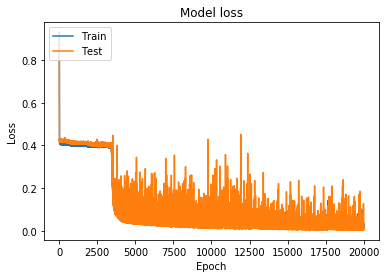

In [118]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.xlim(90000, None)
#plt.ylim(None, 0.1)
plt.show()

In [101]:
# eventually load the model again
model = keras.models.load_model("model_20001_32_1e-3_4x50_3x15_3x15.h5")

In [102]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           2550        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           2550        dense_1[0][0]                    
______________________________________________________________________________________________

In [103]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model)

In [104]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [106]:
print(MAE_list_C)
print(np.mean(MAE_boxplot_C_flat))

[0.06873983441961269, 1.3901613285280254, 1.131828108303983, 1.3717486129866725, 1.6567139228185004, 1.5664960107495685, 1.8273449885217767, 1.9478440586524695, 2.417588580738414, 2.630367453505354]
1.5784403555372382


(-0.1, 10)

<Figure size 432x288 with 0 Axes>

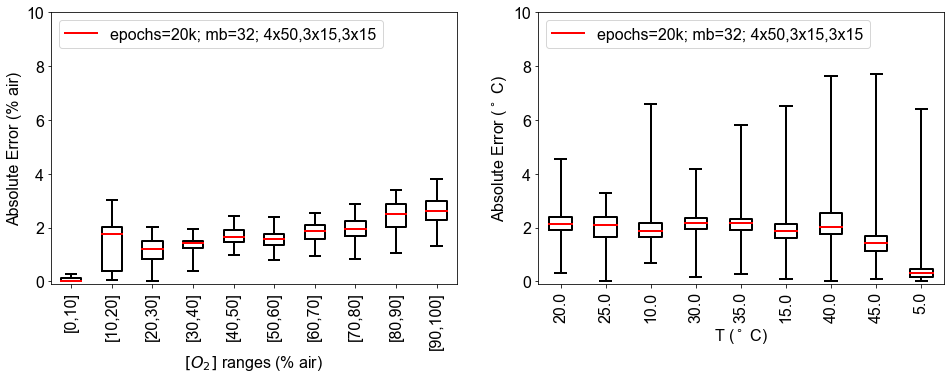

In [85]:
maxy = 10.0


plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)



bp = ax.boxplot(MAE_boxplot_C, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='epochs=20k; mb=32; 4x50,3x15,3x15',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,maxy)




ax = fig.add_subplot(1, 2, 2)


bp = ax.boxplot(MAET_boxplot_C_MTL, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='epochs=20k; mb=32; 4x50,3x15,3x15',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAET_xticks_C_MTL)+1), MAET_xticks_C_MTL, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error ($^\circ$ C)', fontsize = 16)
plt.xlabel('T ($^\circ$ C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,10)

#fig.savefig('../paper/results_theta90.eps')

## KDEs

/Users/umberto/Python-Environments/tfenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

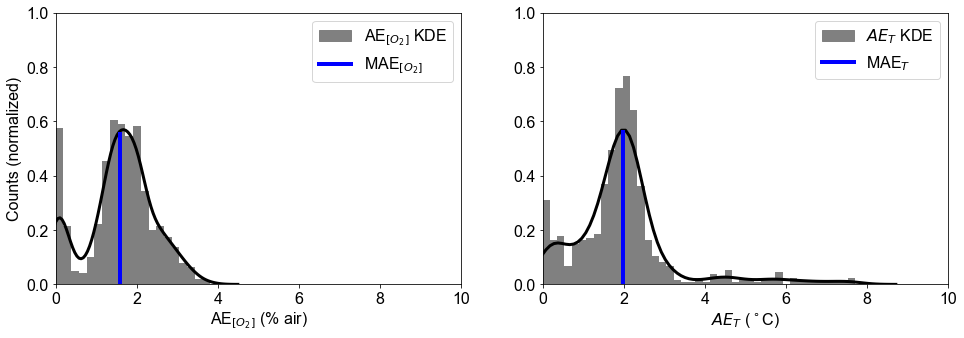

In [86]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ KDE', 'MAE$_{[O_2]}$'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 1.0)
plt.xlim(0, 10)

m_ = np.mean(MAE_boxplot_C_flat)

plt.plot([m_, m_], [0, 0.555], lw = 4, color = 'blue')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['$AE_T$ KDE', 'MAE$_T$'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 1.0)
plt.xlim(0, 10)

m_ = np.mean(MAET_boxplot_C_MTL_flat)

plt.plot([m_, m_], [0, 0.56], lw = 4, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.svg', format='svg', dpi=300,bbox_inches='tight')

In [64]:
np.sum(np.array(MAE_boxplot_C_flat) < 2.19)/len(MAE_boxplot_C_flat)

0.8008241758241759

100% ->  3.9000000000000004
80% ->  2.19


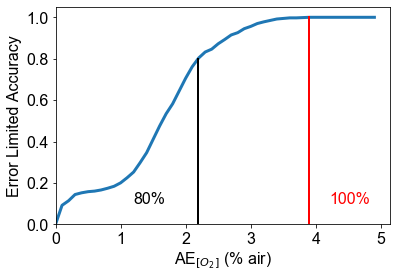

In [65]:
ax = []
xarray = np.arange(0, 5, 0.1)
for x_ in xarray:
    ax.append(np.sum(np.array(MAE_boxplot_C_flat) < x_)/len(MAE_boxplot_C_flat))
    
minidx = np.min(np.where(np.array(ax) > 0.9999))


fig = plt.figure()
plt.plot(np.arange(0, 5, 0.1), ax, lw = 3)
plt.tick_params(labelsize=16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.ylabel('Error Limited Accuracy', fontsize = 16)
plt.xlim(0,None)
plt.ylim(0, None)

#plt.plot([1.1957, 1.1957], [0, 0.25], lw = 2, color = 'black')
#plt.text(0.3,0.3,'25%', fontsize = 16)

plt.plot([2.19, 2.19], [0, 0.8], lw = 2, color = 'black')
#plt.plot([0, 2.19], [0.8, 0.8], lw = 2, color = 'black')
plt.text(1.2,0.1,'80%', fontsize = 16)


plt.plot([xarray[minidx], xarray[minidx]], [0, 1.0], lw = 2, color = 'red')

plt.text(4.2,0.1,'100%', fontsize = 16, color = 'red')
print('100% -> ', xarray[minidx])
print('80% -> ', 2.19)

plt.show()

fig.savefig('../paper/ELA_model_20001_32_1e-3_4x50_3x15_3x15_theta90.svg', format='svg', dpi=300,bbox_inches='tight')

## Simpler network

In [137]:
model4 = get_compiled_model_1() # Simpler network
H2 = fit_model(model4, in_epochs = 100001, in_batch_size = 32, in_epoch_interval_measure_time = 5000, in_epoch_interval_print_progress = 2500)
model4.save("model_100001_32_1e-3_3x50_2x5_2x5.h5")

Just finished epoch 0
Loss.             =  0.09317027777433395
Validation MAE_O2 =  26.507148146629333
Validation MAE_T  =  11.319127231836319
Training   MAE_O2 =  26.404932141304016
Training   MAE_T  =  11.274452358484268
Just finished epoch 0
Just finished epoch 2500
Just finished epoch 5000
Loss.             =  0.000331345567246899
Validation MAE_O2 =  0.8256543427705765
Validation MAE_T  =  1.404909985139966
Training   MAE_O2 =  1.4161651954054832
Training   MAE_T  =  2.172842938452959
5000 epochs - Estimated time to run: 1004.71 seconds, 16.75 minutes, 0.28 hours.
Just finished epoch 5000
Just finished epoch 7500
Just finished epoch 10000
Loss.             =  8.370073192054406e-05
Validation MAE_O2 =  1.6062915325164795
Validation MAE_T  =  2.7720393799245358
Training   MAE_O2 =  0.6567986682057381
Training   MAE_T  =  1.004678886383772
5000 epochs - Estimated time to run: 668.50 seconds, 11.14 minutes, 0.19 hours.
Just finished epoch 10000
Just finished epoch 12500
Just finished 

In [36]:
model2 = get_compiled_model_1() # Simpler network
H2 = fit_model(model2, in_epochs = 20001, in_batch_size = 32, in_epoch_interval_measure_time = 500, in_epoch_interval_print_progress = 500)
model2.save("model_20001_32_1e-3_3x50_2x5_2x5.h5")

Just finished epoch 0
Loss.             =  0.09247762709856033
Validation MAE_O2 =  26.504501700401306
Validation MAE_T  =  12.393270134925842
Training   MAE_O2 =  26.25834047794342
Training   MAE_T  =  12.861862778663635
Just finished epoch 0
500 epochs - Estimated time to run: 76.28 seconds, 1.27 minutes, 0.02 hours.
Just finished epoch 500
Just finished epoch 1000
Loss.             =  0.010857290588319302
Validation MAE_O2 =  8.222056925296783
Validation MAE_T  =  9.849510043859482
Training   MAE_O2 =  8.236376196146011
Training   MAE_T  =  9.657701924443245
500 epochs - Estimated time to run: 72.13 seconds, 1.20 minutes, 0.02 hours.
Just finished epoch 1000
500 epochs - Estimated time to run: 73.34 seconds, 1.22 minutes, 0.02 hours.
Just finished epoch 1500
Just finished epoch 2000
Loss.             =  0.0012801828561350703
Validation MAE_O2 =  4.374073073267937
Validation MAE_T  =  5.325206480920315
Training   MAE_O2 =  2.817106246948242
Training   MAE_T  =  3.9463378116488457
500

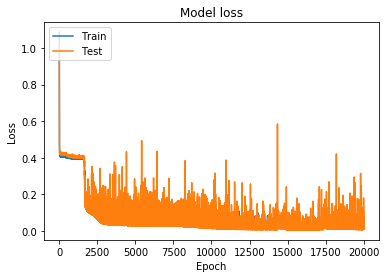

In [37]:
plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.xlim(90000, None)
#plt.ylim(None, 0.1)
plt.show()

In [107]:
# Eventually load the model again
model = keras.models.load_model("model_20001_32_1e-3_3x50_2x5_2x5.h5")

In [108]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           2550        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           2550        dense_1[0][0]                    
______________________________________________________________________________________________

In [109]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model)

In [113]:
MAE_boxplot_C_2, MAE_list_C_2, MAE_xticks_C_2 = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL_2, MAET_list_C_MTL_2, MAET_xticks_C_MTL_2 = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAE_boxplot_C_flat_2 = [item for sublist in MAE_boxplot_C_2 for item in sublist]
MAET_boxplot_C_MTL_flat_2 = [item for sublist in MAET_boxplot_C_MTL_2 for item in sublist]

In [114]:
print(MAE_list_C_2)
print(np.mean(MAE_boxplot_C_flat_2))

[0.14425078106774808, 2.2521701353053523, 1.348282308645651, 1.2189798388216246, 1.2084147135416654, 1.2196332216262795, 1.408922578159132, 1.5852960906451283, 1.5059255686673243, 1.8802897377711985]
1.3673768710801737


(-0.1, 20)

<Figure size 432x288 with 0 Axes>

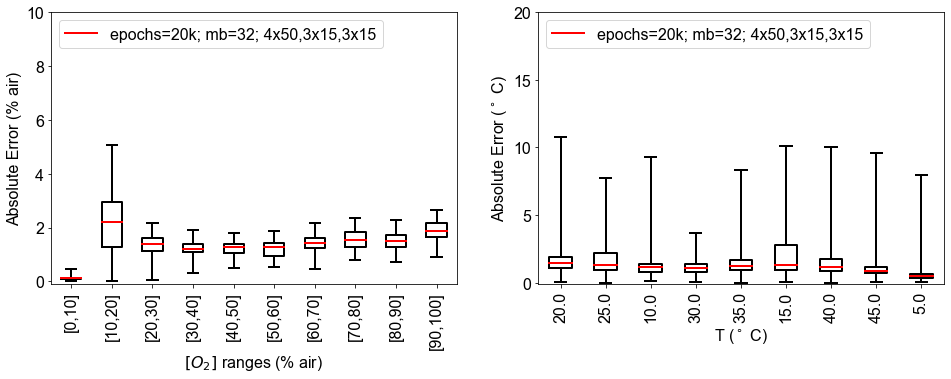

In [115]:
maxy = 10.0


plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)



bp = ax.boxplot(MAE_boxplot_C_2, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='epochs=20k; mb=32; 4x50,3x15,3x15',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAE_xticks_C_2)+1), MAE_xticks_C_2, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,maxy)




ax = fig.add_subplot(1, 2, 2)


bp = ax.boxplot(MAET_boxplot_C_MTL_2, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='epochs=20k; mb=32; 4x50,3x15,3x15',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAET_xticks_C_MTL_2)+1), MAET_xticks_C_MTL_2, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error ($^\circ$ C)', fontsize = 16)
plt.xlabel('T ($^\circ$ C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,20)

#fig.savefig('../paper/results_theta90.eps')

/Users/umberto/Python-Environments/tfenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

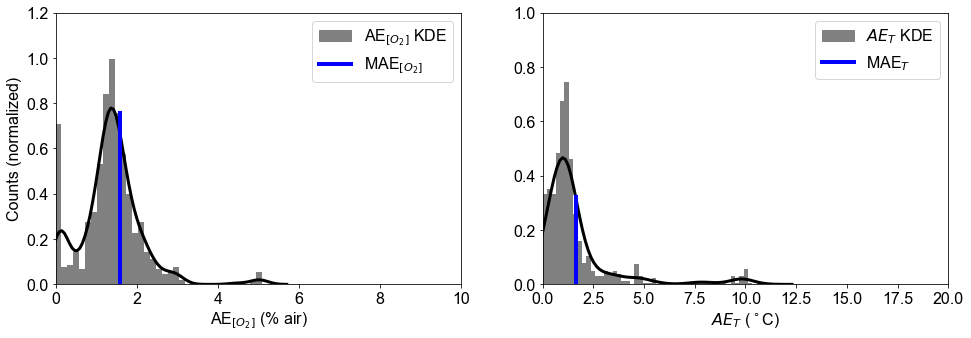

W0220 20:29:33.272879 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 20:29:33.273684 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 20:29:33.329567 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 20:29:33.330224 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 20:29:33.561285 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 20:29:33.561895 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 20:29:33.615989 4724334016 b

In [116]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat_2, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ KDE', 'MAE$_{[O_2]}$'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 1.2)
plt.xlim(0, 10)

m_ = np.mean(MAE_boxplot_C_flat)

plt.plot([m_, m_], [0, 0.755], lw = 4, color = 'blue')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat_2,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['$AE_T$ KDE', 'MAE$_T$'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 1.0)
plt.xlim(0, 20)

m_ = np.mean(MAET_boxplot_C_MTL_flat_2)

plt.plot([m_, m_], [0, 0.32], lw = 4, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

# No mini-batch, (A)

In [187]:
model4 = get_compiled_model_1() # Simpler network
H2 = fit_model(model4, in_epochs = 20001, in_batch_size = 4000, in_epoch_interval_measure_time = 2000, in_epoch_interval_print_progress = 1000)
model4.save("model_20001_4000_1e-3_3x50_2x5_2x5.h5")

Just finished epoch 0
Loss.             =  0.14264392852783203
Validation MAE_O2 =  31.915661692619324
Validation MAE_T  =  11.320002973079681
Training   MAE_O2 =  31.085792183876038
Training   MAE_T  =  11.13085962831974
Just finished epoch 0
Just finished epoch 1000
2000 epochs - Estimated time to run: 20.85 seconds, 0.35 minutes, 0.01 hours.
Just finished epoch 2000
Just finished epoch 3000
2000 epochs - Estimated time to run: 20.86 seconds, 0.35 minutes, 0.01 hours.
Just finished epoch 4000
Just finished epoch 5000
Loss.             =  0.01762697659432888
Validation MAE_O2 =  10.451781004667282
Validation MAE_T  =  8.689052984118462
Training   MAE_O2 =  10.34657433629036
Training   MAE_T  =  8.62028181552887
Just finished epoch 5000
2000 epochs - Estimated time to run: 20.96 seconds, 0.35 minutes, 0.01 hours.
Just finished epoch 6000
Just finished epoch 7000
2000 epochs - Estimated time to run: 21.60 seconds, 0.36 minutes, 0.01 hours.
Just finished epoch 8000
Just finished epoch 90

# More epochs

In [138]:
# TO RUN
model5 = get_compiled_model()
H = fit_model(model5, in_epochs = 100001, in_batch_size = 32, in_epoch_interval_measure_time = 5000, in_epoch_interval_print_progress = 2500)
model5.save("model_100001_32_1e-3_4x50_3x15_3x15.h5")

Just finished epoch 0
Loss.             =  0.0912824422121048
Validation MAE_O2 =  26.48395001888275
Validation MAE_T  =  11.453591734170914
Training   MAE_O2 =  26.151850819587708
Training   MAE_T  =  12.633165568113327
Just finished epoch 0
Just finished epoch 2500
Just finished epoch 5000
Loss.             =  0.000637528020888567
Validation MAE_O2 =  1.2984943576157093
Validation MAE_T  =  2.2139897011220455
Training   MAE_O2 =  1.8785052001476288
Training   MAE_T  =  2.626916617155075
5000 epochs - Estimated time to run: 762.30 seconds, 12.71 minutes, 0.21 hours.
Just finished epoch 5000
Just finished epoch 7500
Just finished epoch 10000
Loss.             =  0.00046497592120431364
Validation MAE_O2 =  2.473827637732029
Validation MAE_T  =  2.4910283647477627
Training   MAE_O2 =  1.626102440059185
Training   MAE_T  =  2.154999040067196
5000 epochs - Estimated time to run: 835.45 seconds, 13.92 minutes, 0.23 hours.
Just finished epoch 10000
Just finished epoch 12500
Just finished epo

KeyboardInterrupt: 

In [125]:
model3 = get_compiled_model()
H = fit_model(model3, in_epochs = 30001, in_batch_size = 32, in_epoch_interval_measure_time = 500, in_epoch_interval_print_progress = 500)
model3.save("model_30001_32_1e-3_4x50_3x15_3x15.h5")

Just finished epoch 0
Loss.             =  0.09195532649755478
Validation MAE_O2 =  26.47528052330017
Validation MAE_T  =  11.31958320736885
Training   MAE_O2 =  26.23375654220581
Training   MAE_T  =  11.228683814406395
Just finished epoch 0
500 epochs - Estimated time to run: 82.69 seconds, 1.38 minutes, 0.02 hours.
Just finished epoch 500
Just finished epoch 1000
Loss.             =  0.01054775808006525
Validation MAE_O2 =  8.200328052043915
Validation MAE_T  =  9.778947159647942
Training   MAE_O2 =  8.10125321149826
Training   MAE_T  =  9.640408381819725
500 epochs - Estimated time to run: 91.24 seconds, 1.52 minutes, 0.03 hours.
Just finished epoch 1000
500 epochs - Estimated time to run: 73.74 seconds, 1.23 minutes, 0.02 hours.
Just finished epoch 1500
Just finished epoch 2000
Loss.             =  0.0014991569332778454
Validation MAE_O2 =  2.4193990975618362
Validation MAE_T  =  3.6330437287688255
Training   MAE_O2 =  3.072495199739933
Training   MAE_T  =  4.221581406891346
500 ep

# Results from the model

In [163]:
# Eventually load the model again
model = keras.models.load_model("model_100001_32_1e-3_3x50_2x5_2x5.h5")

In [164]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model)

In [165]:
MAE_boxplot_C_3, MAE_list_C_3, MAE_xticks_C_3 = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL_3, MAET_list_C_MTL_3, MAET_xticks_C_MTL_3 = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAE_boxplot_C_flat_3 = [item for sublist in MAE_boxplot_C_3 for item in sublist]
MAET_boxplot_C_MTL_flat_3 = [item for sublist in MAET_boxplot_C_MTL_3 for item in sublist]

In [166]:
print(MAE_list_C_3)
print(np.mean(MAE_boxplot_C_flat_3))
print(np.mean(MAET_boxplot_C_MTL_flat_3))

[0.06314535176448792, 0.1624194808202247, 0.2208781032495092, 0.17740046812428473, 0.2178817907969147, 0.23302482020470303, 0.2274247533396667, 0.27714311322079543, 0.3442054878581645, 0.2875853893233517]
0.21707888660635186
0.2678020759707401


<Figure size 432x288 with 0 Axes>

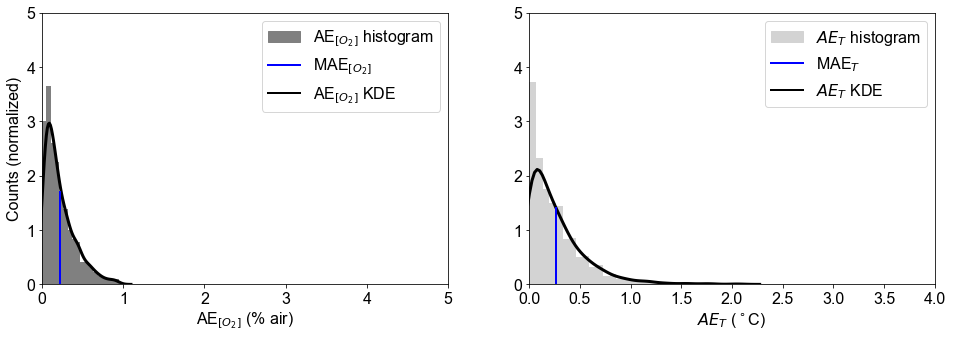

In [186]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ histogram', 'MAE$_{[O_2]}$', 'AE$_{[O_2]}$ KDE'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 5)
plt.xlim(0, 5)

m_ = np.mean(MAE_boxplot_C_flat_3)

plt.plot([m_, m_], [0, 1.7], lw = 2, color = 'blue')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat_3,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "lightgray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='lightgray', edgecolor='lightgray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['$AE_T$ histogram', 'MAE$_T$', '$AE_T$ KDE'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 5.0)
plt.xlim(0, 4)

m_ = np.mean(MAET_boxplot_C_MTL_flat_3)

plt.plot([m_, m_], [0, 1.4], lw = 2, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

# Comparison between the two networks

<Figure size 432x288 with 0 Axes>

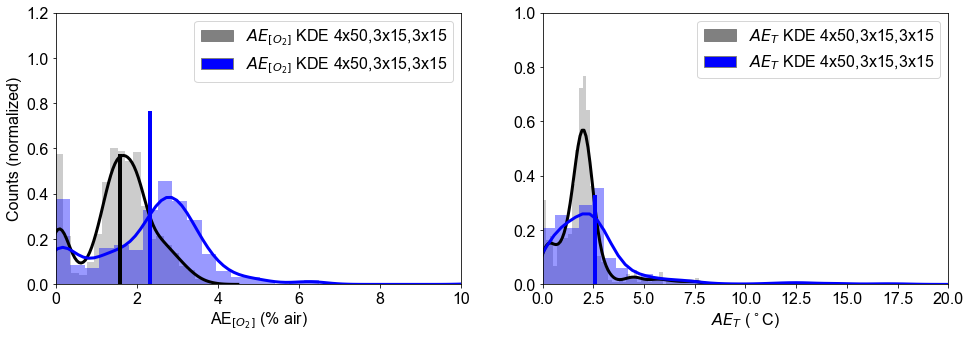

W0220 22:02:12.834388 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.835355 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.836024 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.836899 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.837621 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.838819 4724334016 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 22:02:12.839668 4724334016 b

In [135]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAE_boxplot_C_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['$AE_{[O_2]}$ KDE 4x50,3x15,3x15', '$AE_{[O_2]}$ KDE 4x50,3x15,3x15'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 1.2)
plt.xlim(0, 10)

m_ = np.mean(MAE_boxplot_C_flat)
m_3_ = np.mean(MAE_boxplot_C_flat_3)

plt.plot([m_, m_], [0, 0.565], lw = 4, color = 'black')
plt.plot([m_3_, m_3_], [0, 0.755], lw = 4, color = 'blue')



ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "gray"})

sns.distplot(MAET_boxplot_C_MTL_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE 2',rug_kws={"color": "gray"},
                  kde_kws={"color": "blue", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 0.4, "color": "blue"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE 4x50,3x15,3x15'),
                Patch(facecolor='blue', edgecolor='gray',
                         label='$AE_T$ KDE 3x50,2x5,2x5'),
                Line2D([0], [0], color='blue', lw=4)
                ]

ax.legend(custom_lines, ['$AE_T$ KDE 4x50,3x15,3x15', '$AE_T$ KDE 4x50,3x15,3x15'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 1.0)
plt.xlim(0, 20)

m_ = np.mean(MAET_boxplot_C_MTL_flat_3)

plt.plot([m_, m_], [0, 0.32], lw = 4, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

# Predictions of models

## Functions to get the predictions

In [120]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df, preds_exp_T_df = get_predictions(model4)

In [121]:
#(O2T, O2, T) = model4.predict(data_dev)
#preds_exp_df = pd.DataFrame(O2T)
#preds_exp_df.columns = ['O2', 'T']
#preds_exp_o2_df = pd.DataFrame(O2[:,0])
#preds_exp_o2_df.columns = ['O2']

#preds_exp_T_df = pd.DataFrame(T[:,0])
#preds_exp_T_df.columns = ['T']

In [122]:
#targets_dev = targets_dev.reset_index(drop = True)
#preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
#preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [123]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)

In [124]:
MAE_list_C

[0.06873983441961269,
 1.3901613285280254,
 1.131828108303983,
 1.3717486129866725,
 1.6567139228185004,
 1.5664960107495685,
 1.8273449885217767,
 1.9478440586524695,
 2.417588580738414,
 2.630367453505354]

In [125]:
np.mean(MAE_list_C) 
# 64/32/32 -->
# 50       -->
# 80       -->

1.6008832899224377

<Figure size 432x288 with 0 Axes>

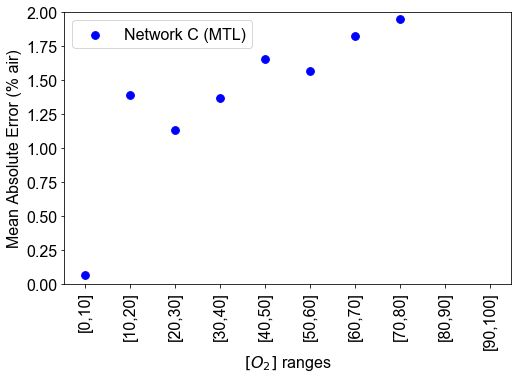

In [126]:
maxx = 4.0

plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(1, 1, 1)

#bp = ax.scatter(range(1,len(MAE_xticks50)+1),MAE_list50, s = 60, color = 'black', label = 'Network A (50/50/50)')
#bp = ax.scatter(range(1,len(MAE_xticks_MTL)+1),MAE_list_MTL, s = 60, color = 'red', label = 'Network B (MTL)')
bp = ax.scatter(range(1,len(MAE_xticks_C)+1),MAE_list_C, s = 60, color = 'blue', label = 'Network C (MTL)')
plt.ylim(0, 2)
plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')
#plt.grid()
plt.ylabel('Mean Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges', fontsize = 16)
plt.tick_params(labelsize=16)
plt.legend(loc = 'upper left', fontsize = 16)
#plt.xlim(0,9.5)


#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

W0220 16:34:13.607456 4642483648 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 16:34:13.608336 4642483648 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 16:34:13.698975 4642483648 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 16:34:13.699743 4642483648 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

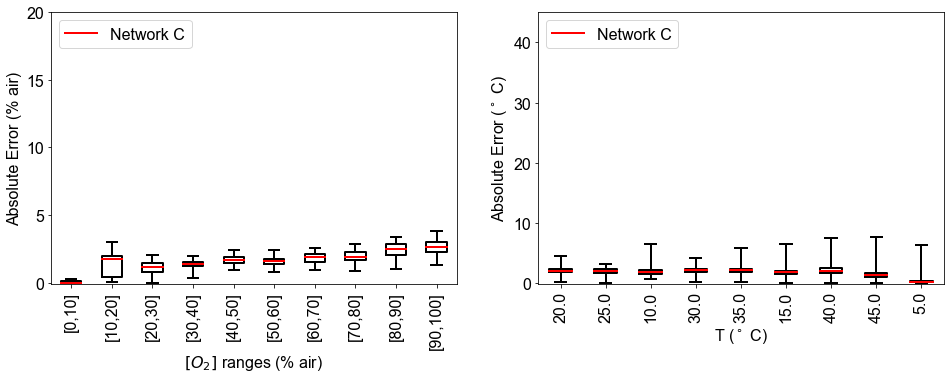

In [127]:
maxy = 20.0


plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)



bp = ax.boxplot(MAE_boxplot_C, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,maxy)




ax = fig.add_subplot(1, 2, 2)


bp = ax.boxplot(MAET_boxplot_C_MTL, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAET_xticks_C_MTL)+1), MAET_xticks_C_MTL, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error ($^\circ$ C)', fontsize = 16)
plt.xlabel('T ($^\circ$ C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,45)

fig.savefig('../paper/results_theta90.eps')

In [ ]:
pdo2 = pd.DataFrame({'MAE_list': MAE_list_C, 'MAE_xticks': MAE_xticks_C, 'MAE_boxplot': MAE_boxplot_C})
pdT = pd.DataFrame({'MAET_list': MAET_list_C_MTL,'MAET_boxplot': MAET_boxplot_C_MTL, 'MAET_xticks':MAET_xticks_C_MTL})
pdo2.to_csv('/content/gdrive/My Drive/data/netc_O2.csv')
pdT.to_csv('/content/gdrive/My Drive/data/netc_T.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/data/netc_O2.csv'

In [ ]:
np.mean(MAE_list_C)

1.7852302603341024

In [ ]:
np.mean(MAET_list_C_MTL)

2.105622284124125

In [ ]:
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]
#type(MAE_boxplot_C)

<Figure size 432x288 with 0 Axes>

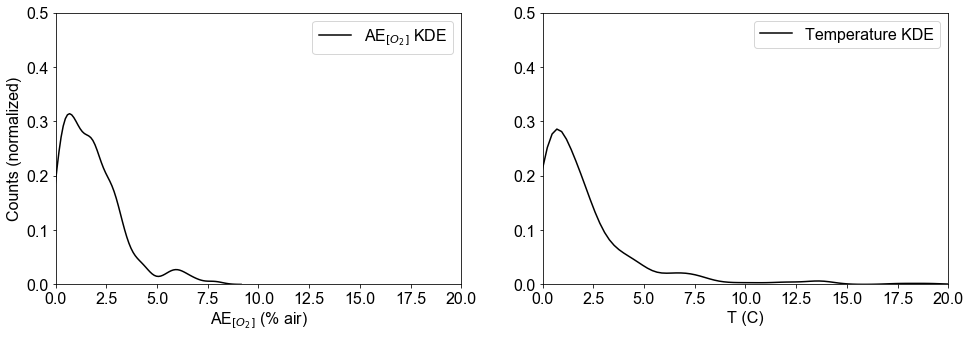

In [ ]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'black', hist = False, label = 'AE$_{[O_2]}$ KDE')


ax.legend( fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 0.5)
plt.xlim(0, 20)


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,  color = 'black', hist = False, label = 'Temperature KDE')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('T (C)', fontsize = 16)
plt.tick_params(labelsize=16)
ax.legend( fontsize = 16)
plt.ylim(0, 0.5)
plt.xlim(0, 20)




plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

# VERSIONS

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

In [ ]:
p